In [ ]:
import os
import cv2

In [2]:
!pip install keras-preprocessing

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.2 MB/s eta 0:00:00


In [13]:
!pip install utils

In [18]:
!pip install tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 14.0 MB/s eta 0:00:0000:010:01
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tfx-bsl 1.12.0 requires google-api-python-client<2,>=1.7.11, but you have google-api-python-client 2.83.0 which is incompatible.
onnx 1.13.1 requires protobuf<4,>=3.20.2, but you have protobuf 3.19.6 which is incompatible.
apache-beam 2.44.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.6 which is incompatible.


In [3]:
images=[]
masks=[]
imagefolder="/kaggle/input/ravir-segmentation/RAVIR Dataset/train/training_images/"
maskfolder="/kaggle/input/ravir-segmentation/RAVIR Dataset/train/training_masks/"
for file in os.listdir(imagefolder):
    print(file)
    X=cv2.imread(os.path.join(imagefolder,file))
    images.append(X/255.)
for mask in os.listdir(maskfolder):
    print(mask)
    y=cv2.imread(os.path.join(maskfolder,mask))
    masks.append(y/255.)

IR_Case_035.png
IR_Case_020.png
IR_Case_022.png
IR_Case_011.png
IR_Case_040.png
IR_Case_055.png
IR_Case_036.png
IR_Case_026.png
IR_Case_056.png
IR_Case_038.png
IR_Case_051.png
IR_Case_017.png
IR_Case_044.png
IR_Case_034.png
IR_Case_021.png
IR_Case_041.png
IR_Case_023.png
IR_Case_019.png
IR_Case_053.png
IR_Case_049.png
IR_Case_052.png
IR_Case_058.png
IR_Case_043.png
IR_Case_035.png
IR_Case_020.png
IR_Case_022.png
IR_Case_011.png
IR_Case_040.png
IR_Case_055.png
IR_Case_036.png
IR_Case_026.png
IR_Case_056.png
IR_Case_038.png
IR_Case_051.png
IR_Case_017.png
IR_Case_044.png
IR_Case_034.png
IR_Case_021.png
IR_Case_041.png
IR_Case_023.png
IR_Case_019.png
IR_Case_053.png
IR_Case_049.png
IR_Case_052.png
IR_Case_058.png
IR_Case_043.png


In [4]:
print(len(masks),len(images))

23 23


In [5]:
import matplotlib.pyplot as plt

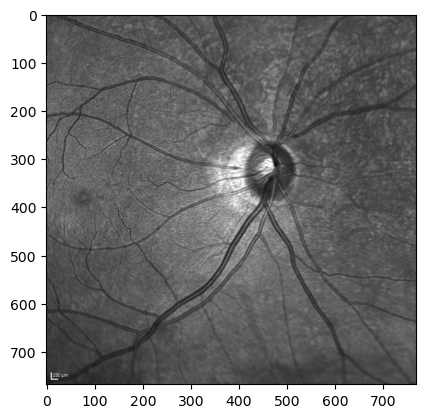

In [6]:
plt.imshow(images[0])

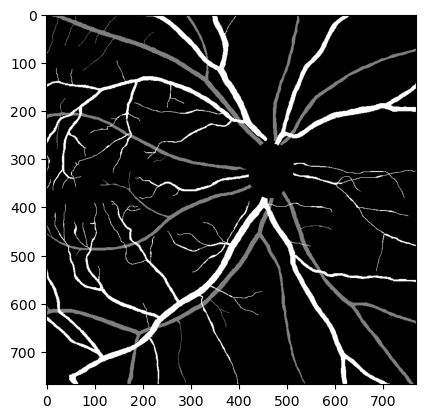

In [7]:
plt.imshow(masks[0])

In [8]:
images[0].shape

(768, 768, 3)

In [10]:
import numpy as np
from keras_preprocessing import image


def random_flip(img, mask, u=0.5):
    if np.random.random() < u:
        img = image.flip_axis(img, 1)
        mask = image.flip_axis(mask, 1)
    if np.random.random() < u:
        img = image.flip_axis(img, 0)
        mask = image.flip_axis(mask, 0)
    return img, mask


def random_rotate(img, mask, rotate_limit=(-20, 20), u=0.5):
    if np.random.random() < u:
        theta = np.random.uniform(rotate_limit[0], rotate_limit[1])
        img = image.apply_affine_transform(img, theta=theta)
        mask = image.apply_affine_transform(mask, theta=theta)
    return img, mask


def shift(x, wshift, hshift, row_axis=0, col_axis=1, channel_axis=2, fill_mode='nearest', cval=0.):
    h, w = x.shape[row_axis], x.shape[col_axis]
    tx = hshift * h
    ty = wshift * w
    x = image.apply_affine_transform(x, ty=ty, tx=tx)
    return x


def random_shift(img, mask, w_limit=(-0.1, 0.1), h_limit=(-0.1, 0.1), u=0.5):
    if np.random.random() < u:
        wshift = np.random.uniform(w_limit[0], w_limit[1])
        hshift = np.random.uniform(h_limit[0], h_limit[1])
        img = shift(img, wshift, hshift)
        mask = shift(mask, wshift, hshift)
    return img, mask


def random_zoom(img, mask, zoom_range=(0.8, 1), u=0.5):
    if np.random.random() < u:
        zx, zy = np.random.uniform(zoom_range[0], zoom_range[1], 2)
        img = image.apply_affine_transform(img, zx=zx, zy=zy)
        mask = image.apply_affine_transform(mask, zx=zx, zy=zy)
    return img, mask


def random_shear(img, mask, intensity_range=(-0.5, 0.5), u=0.5):
    if np.random.random() < u:
        sh = np.random.uniform(-intensity_range[0], intensity_range[1])
        img = image.apply_affine_transform(img, shear=sh)
        mask = image.apply_affine_transform(mask, shear=sh)
    return img, mask


def random_gray(img, u=0.5):
    if np.random.random() < u:
        coef = np.array([[[0.114, 0.587, 0.299]]])  # rgb to gray (YCbCr)
        gray = np.sum(img * coef, axis=2)
        img = np.dstack((gray, gray, gray))
    return img


def random_contrast(img, limit=(-0.3, 0.3), u=0.5):
    if np.random.random() < u:
        alpha = 1.0 + np.random.uniform(limit[0], limit[1])
        coef = np.array([[[0.114, 0.587, 0.299]]])  # rgb to gray (YCbCr)
        gray = img * coef
        gray = (3.0 * (1.0 - alpha) / gray.size) * np.sum(gray)
        img = alpha * img + gray
        img = np.clip(img, 0., 1.)
    return img


def random_brightness(img, limit=(-0.3, 0.3), u=0.5):
    if np.random.random() < u:
        alpha = 1.0 + np.random.uniform(limit[0], limit[1])
        img = alpha * img
        img = np.clip(img, 0., 1.)
    return img


def random_saturation(img, limit=(-0.3, 0.3), u=0.5):
    if np.random.random() < u:
        alpha = 1.0 + np.random.uniform(limit[0], limit[1])
        coef = np.array([[[0.114, 0.587, 0.299]]])
        gray = img * coef
        gray = np.sum(gray, axis=2, keepdims=True)
        img = alpha * img + (1. - alpha) * gray
        img = np.clip(img, 0., 1.)
    return img


def random_channel_shift(x, limit, channel_axis=2):
    x = np.rollaxis(x, channel_axis, 0)
    min_x, max_x = np.min(x), np.max(x)
    channel_images = [np.clip(x_ch + np.random.uniform(-limit, limit), min_x, max_x) for x_ch in x]
    x = np.stack(channel_images, axis=0)
    x = np.rollaxis(x, 0, channel_axis + 1)
    return x


def random_augmentation(img, mask):
    img = random_brightness(img, limit=(-0.2, 0.2), u=0.5)
    img = random_contrast(img, limit=(-0.2, 0.2), u=0.5)
    img = random_saturation(img, limit=(-0.2, 0.2), u=0.5)
    img, mask = random_rotate(img, mask, rotate_limit=(-180, 180), u=0.5)
    img, mask = random_shear(img, mask, intensity_range=(-5, 5), u=0.05)
    img, mask = random_flip(img, mask, u=0.5)
    img, mask = random_shift(img, mask, w_limit=(-0.1, 0.1), h_limit=(-0.1, 0.1), u=0.05)
    img, mask = random_zoom(img, mask, zoom_range=(0.8, 1.2), u=0.05)
    return img, mask

In [22]:
import h5py
import keras.backend as K
import numpy as np
import os
import os.path
import tensorflow as tf
import threading
from PIL import Image
from keras import backend as K
from keras import losses
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.layers import Input, MaxPooling2D
from keras.layers import concatenate, Conv2D, Conv2DTranspose, Dropout, ReLU, BatchNormalization, Activation
from keras.layers import add, multiply
from keras.models import Model
from keras.optimizers import Adam
from numpy import random
from random import randint
#from utils import data_augmentation, prepare_dataset


def get_unet(minimum_kernel=32, do=0, activation=ReLU, iteration=1):
    inputs = Input((None, None, 3))
    conv1 = Dropout(do)(activation()(Conv2D(minimum_kernel, (3, 3), padding='same')(inputs)))
    conv1 = Dropout(do)(activation()(Conv2D(minimum_kernel, (3, 3), padding='same')(conv1)))
    a = conv1
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Dropout(do)(activation()(Conv2D(minimum_kernel * 2, (3, 3), padding='same')(pool1)))
    conv2 = Dropout(do)(activation()(Conv2D(minimum_kernel * 2, (3, 3), padding='same')(conv2)))
    b = conv2
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Dropout(do)(activation()(Conv2D(minimum_kernel * 4, (3, 3), padding='same')(pool2)))
    conv3 = Dropout(do)(activation()(Conv2D(minimum_kernel * 4, (3, 3), padding='same')(conv3)))
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Dropout(do)(activation()(Conv2D(minimum_kernel * 8, (3, 3), padding='same')(pool3)))
    conv4 = Dropout(do)(activation()(Conv2D(minimum_kernel * 8, (3, 3), padding='same')(conv4)))
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Dropout(do)(activation()(Conv2D(minimum_kernel * 16, (3, 3), padding='same')(pool4)))
    conv5 = Dropout(do)(activation()(Conv2D(minimum_kernel * 16, (3, 3), padding='same')(conv5)))

    up6 = concatenate([Conv2DTranspose(minimum_kernel * 8, (2, 2), strides=(2, 2), padding='same')(conv5), conv4],
                      axis=3)
    conv6 = Dropout(do)(activation()(Conv2D(minimum_kernel * 8, (3, 3), padding='same')(up6)))
    conv6 = Dropout(do)(activation()(Conv2D(minimum_kernel * 8, (3, 3), padding='same')(conv6)))

    up7 = concatenate([Conv2DTranspose(minimum_kernel * 4, (2, 2), strides=(2, 2), padding='same')(conv6), conv3],
                      axis=3)
    conv7 = Dropout(do)(activation()(Conv2D(minimum_kernel * 4, (3, 3), padding='same')(up7)))
    conv7 = Dropout(do)(activation()(Conv2D(minimum_kernel * 4, (3, 3), padding='same')(conv7)))

    up8 = concatenate([Conv2DTranspose(minimum_kernel * 2, (2, 2), strides=(2, 2), padding='same')(conv7), conv2],
                      axis=3)
    conv8 = Dropout(do)(activation()(Conv2D(minimum_kernel * 2, (3, 3), padding='same')(up8)))
    conv8 = Dropout(do)(activation()(Conv2D(minimum_kernel * 2, (3, 3), padding='same')(conv8)))

    up9 = concatenate([Conv2DTranspose(minimum_kernel, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Dropout(do)(activation()(Conv2D(minimum_kernel, (3, 3), padding='same')(up9)))
    conv9 = Dropout(do)(activation()(Conv2D(minimum_kernel, (3, 3), padding='same')(conv9)))

    pt_conv1a = Conv2D(minimum_kernel, (3, 3), padding='same')
    pt_activation1a = activation()
    pt_dropout1a = Dropout(do)
    pt_conv1b = Conv2D(minimum_kernel, (3, 3), padding='same')
    pt_activation1b = activation()
    pt_dropout1b = Dropout(do)
    pt_pooling1 = MaxPooling2D(pool_size=(2, 2))

    pt_conv2a = Conv2D(minimum_kernel * 2, (3, 3), padding='same')
    pt_activation2a = activation()
    pt_dropout2a = Dropout(do)
    pt_conv2b = Conv2D(minimum_kernel * 2, (3, 3), padding='same')
    pt_activation2b = activation()
    pt_dropout2b = Dropout(do)
    pt_pooling2 = MaxPooling2D(pool_size=(2, 2))

    pt_conv3a = Conv2D(minimum_kernel * 4, (3, 3), padding='same')
    pt_activation3a = activation()
    pt_dropout3a = Dropout(do)
    pt_conv3b = Conv2D(minimum_kernel * 4, (3, 3), padding='same')
    pt_activation3b = activation()
    pt_dropout3b = Dropout(do)

    pt_tranconv8 = Conv2DTranspose(minimum_kernel * 2, (2, 2), strides=(2, 2), padding='same')
    pt_conv8a = Conv2D(minimum_kernel * 2, (3, 3), padding='same')
    pt_activation8a = activation()
    pt_dropout8a = Dropout(do)
    pt_conv8b = Conv2D(minimum_kernel * 2, (3, 3), padding='same')
    pt_activation8b = activation()
    pt_dropout8b = Dropout(do)

    pt_tranconv9 = Conv2DTranspose(minimum_kernel, (2, 2), strides=(2, 2), padding='same')
    pt_conv9a = Conv2D(minimum_kernel, (3, 3), padding='same')
    pt_activation9a = activation()
    pt_dropout9a = Dropout(do)
    pt_conv9b = Conv2D(minimum_kernel, (3, 3), padding='same')
    pt_activation9b = activation()
    pt_dropout9b = Dropout(do)

    conv9s = [conv9]
    outs = []
    a_layers = [a]
    for iteration_id in range(iteration):
        out = Conv2D(1, (1, 1), activation='sigmoid', name=f'out1{iteration_id + 1}')(conv9s[-1])
        outs.append(out)

        model = Model(inputs=[inputs], outputs=[outs[-1]])
        count = 0
        for i, layer in enumerate(model.layers):
            if not layer.name.startswith('out'):
                count += 1

        conv1 = pt_dropout1a(pt_activation1a(pt_conv1a(conv9s[-1])))
        conv1 = pt_dropout1b(pt_activation1b(pt_conv1b(conv1)))
        a_layers.append(conv1)
        conv1 = concatenate(a_layers, axis=3)
        conv1 = Conv2D(minimum_kernel, (1, 1), padding='same')(conv1)
        pool1 = pt_pooling1(conv1)

        conv2 = pt_dropout2a(pt_activation2a(pt_conv2a(pool1)))
        conv2 = pt_dropout2b(pt_activation2b(pt_conv2b(conv2)))
        pool2 = pt_pooling2(conv2)

        conv3 = pt_dropout3a(pt_activation3a(pt_conv3a(pool2)))
        conv3 = pt_dropout3b(pt_activation3b(pt_conv3b(conv3)))

        up8 = concatenate([pt_tranconv8(conv3), conv2], axis=3)
        conv8 = pt_dropout8a(pt_activation8a(pt_conv8a(up8)))
        conv8 = pt_dropout8b(pt_activation8b(pt_conv8b(conv8)))

        up9 = concatenate([pt_tranconv9(conv8), conv1], axis=3)
        conv9 = pt_dropout9a(pt_activation9a(pt_conv9a(up9)))
        conv9 = pt_dropout9b(pt_activation9b(pt_conv9b(conv9)))

        conv9s.append(conv9)

    out2 = Conv2D(1, (1, 1), activation='sigmoid', name='final_out')(conv9)
    outs.append(out2)

    model = Model(inputs=[inputs], outputs=outs)
    count = 0
    for i, layer in enumerate(model.layers):
        if not layer.name.startswith('model1_') and not layer.name.startswith('out'):
            layer.name = layer.name[:layer.name.rfind('_')]
            layer.name = f'model2_{layer.name}_{count}'
            count += 1

    loss_funcs = {}
    for iteration_id in range(iteration):
        loss_funcs.update({f'out1{iteration_id + 1}': losses.binary_crossentropy})
    loss_funcs.update({'final_out': losses.binary_crossentropy})

    metrics = {
        "final_out": ['accuracy']
    }

    model.compile(optimizer=Adam(lr=1e-3), loss=loss_funcs, metrics=metrics)

    return model


def random_crop(img, mask, crop_size):
    imgheight = img.shape[0]
    imgwidth = img.shape[1]

    i = randint(0, imgheight - crop_size)
    j = randint(0, imgwidth - crop_size)

    return img[i:(i + crop_size), j:(j + crop_size), :], mask[i:(i + crop_size), j:(j + crop_size)]


class Generator():
    def __init__(self, batch_size, repeat, dataset):
        self.lock = threading.Lock()
        self.dataset = dataset
        with self.lock:
            self.list_images_all = prepare_dataset.getTrainingData(0, self.dataset)
            self.list_gt_all = prepare_dataset.getTrainingData(1, self.dataset)
        self.n = len(self.list_images_all)
        self.index = 0
        self.repeat = repeat
        self.batch_size = batch_size
        self.step = self.batch_size // self.repeat

        if self.repeat >= self.batch_size:
            self.repeat = self.batch_size
            self.step = 1

    def gen(self, au=True, crop_size=48, iteration=None):
      
        while True:
            data_yield = [self.index % self.n,
                          (self.index + self.step) % self.n if (self.index + self.step) < self.n else self.n]
            self.index = (self.index + self.step) % self.n

            list_images_base = self.list_images_all[data_yield[0]:data_yield[1]]
            list_gt_base = self.list_gt_all[data_yield[0]:data_yield[1]]

            list_images_aug = []
            list_gt_aug = []
            for image, gt in zip(list_images_base, list_gt_base):
                if au:
                    if crop_size == prepare_dataset.DESIRED_DATA_SHAPE[0]:
                        for _ in range(self.repeat):
                            image, gt = data_augmentation.random_augmentation(image, gt)
                            list_images_aug.append(image)
                            list_gt_aug.append(gt)
                    else:
                        image, gt = data_augmentation.random_augmentation(image, gt)
                        list_images_aug.append(image)
                        list_gt_aug.append(gt)
                else:
                    list_images_aug.append(image)
                    list_gt_aug.append(gt)

            list_images = []
            list_gt = []

            if crop_size == prepare_dataset.DESIRED_DATA_SHAPE[0]:
                list_images = list_images_aug
                list_gt = list_gt_aug
            else:
                for image, gt in zip(list_images_aug, list_gt_aug):
                    for _ in range(self.repeat):
                        image_, gt_ = random_crop(image, gt, crop_size)

                        list_images.append(image_)
                        list_gt.append(gt_)

            outs = {}
            for iteration_id in range(iteration):
                outs.update({f'out1{iteration_id + 1}': np.array(list_gt)})
            outs.update({'final_out': np.array(list_gt)})
            yield np.array(list_images), 